<a href="https://colab.research.google.com/github/RickyF404/Tesi/blob/main/AEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import gdown

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [2]:
url_no_temp = "https://drive.google.com/uc?id=1jerpsOqjogEnnriBkHOrDDEeh1wJry_o"
output_no_temp = "data_no_temperature.csv"
gdown.download(url_no_temp, output_no_temp)

url_temp = " https://drive.google.com/uc?id=1RofjUHZS_UAnbF6Xe74jTp9z4Mmk7swH"
output_temp = "data_temperature.csv"
gdown.download(url_temp, output_temp)

Downloading...
From: https://drive.google.com/uc?id=1jerpsOqjogEnnriBkHOrDDEeh1wJry_o
To: /content/data_no_temperature.csv
100%|██████████| 1.44M/1.44M [00:00<00:00, 12.3MB/s]
Downloading...
From:  https://drive.google.com/uc?id=1RofjUHZS_UAnbF6Xe74jTp9z4Mmk7swH
To: /content/data_temperature.csv
100%|██████████| 1.66M/1.66M [00:00<00:00, 16.8MB/s]


'data_temperature.csv'

# Ottimizzazione iperparametri (CVAE)

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
df_temp = pd.read_csv("/content/data_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
new_df = df_temp[(df_temp["timestamp"] < end)]

In [ ]:
class CVAE(keras.Model):
    def __init__(self, input_dim, cond_dim, latent_dim, hidden_dims, beta, activation="relu"):
        super(CVAE, self).__init__()
        self.encoder_inputs = keras.Input(shape=(input_dim,))
        self.cond_inputs = keras.Input(shape=(cond_dim,))
        self.concat_enc = layers.Concatenate()
        self.enc_layers = [layers.Dense(h, activation=activation) for h in hidden_dims]
        self.z_mean_layer = layers.Dense(latent_dim)
        self.z_log_var_layer = layers.Dense(latent_dim)
        self.concat_dec = layers.Concatenate()
        self.dec_layers = [layers.Dense(h, activation=activation) for h in reversed(hidden_dims)]
        self.out_layer = layers.Dense(input_dim, activation="linear")
        self.beta = beta

    def call(self, inputs):
        x, c = inputs
        # Encoder
        h = self.concat_enc([x, c])
        for layer in self.enc_layers:
            h = layer(h)
        z_mean = self.z_mean_layer(h)
        z_log_var = self.z_log_var_layer(h)
        # Sampling
        eps = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * eps
        # Decoder
        h_dec = self.concat_dec([z, c])
        for layer in self.dec_layers:
            h_dec = layer(h_dec)
        x_out = self.out_layer(h_dec)
        # Add loss (ricostruzione + KL)
        recon_loss = tf.reduce_sum(tf.square(x - x_out), axis=-1)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.add_loss(tf.reduce_mean(recon_loss + self.beta * kl_loss))
        return x_out

def build_cvae(hp):
  input_dim = 6
  cond_dim = 1
  latent_dim = hp.Int("latent_dim", 2, 2)
  num_layers = hp.Int("num_layers", 2, 3)
  hidden_dim = hp.Int("hidden_dim", 16, 64, step=16)
  activation = hp.Choice("activation", ["relu"])
  lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")
  beta = hp.Float("beta", 0.01, 0.5, step=0.01)
  hidden_dims = [hidden_dim // (2**i) for i in range(num_layers)]
  model = CVAE(input_dim, cond_dim, latent_dim, hidden_dims, beta, activation=activation)
  model.build(input_shape=[(None, input_dim), (None, cond_dim)])
  model.compile(optimizer=keras.optimizers.Adam(lr))
  return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 4
n_months = 12
start_date = new_df["timestamp"].min()

train_end = start_date + pd.DateOffset(months=4)
train_data = new_df[(new_df["timestamp"] < train_end)]

val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_data[features])
T_train = scaler_T.fit_transform(train_data[cond])

X_val = scaler_X.transform(val_data[features])
T_val = scaler_T.transform(val_data[cond])

#Tuner
tuner = kt.Hyperband(
    build_cvae,
    objective="val_loss",
    max_epochs = 50,
    factor = 3,
    directory = "cvae_tuning",
    project_name = "cvae_with_class"
  )


early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
ckpt = ModelCheckpoint("best_cvae.h5", monitor="val_loss", save_best_only=True)

tuner.search(
    [X_train, T_train],
    X_train,
    epochs=50,
    validation_data = ([X_val, T_val], X_val),
    batch_size=128,
    callbacks=[early, ckpt])


best_hp = tuner.get_best_hyperparameters(1)[0]
print("Migliori iperparametri:", best_hp.values)

best_model = tuner.get_best_models(1)[0]
best_model.summary()

Trial 90 Complete [00h 00m 25s]
val_loss: 6.912935256958008

Best val_loss So Far: 5.5088887214660645
Total elapsed time: 00h 13m 40s
Migliori iperparametri: {'latent_dim': 2, 'num_layers': 3, 'hidden_dim': 32, 'activation': 'relu', 'lr': 0.0015285176692896685, 'beta': 0.01, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0056'}


Model: "cvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ concatenate (Concatenate)       │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_1 (Concatenate)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,874 (7.32 KB)

 Trainable params: 1,874 (7.32 KB)

 Non-trainable params: 0 (0.00 B)

# Ottimizzazione iperparametri (VAE senza temperatura)

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
df_temp = pd.read_csv("/content/data_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
new_df = df_temp[(df_temp["timestamp"] < end)]

In [ ]:
class VAE(keras.Model):
  def __init__(self, input_dim, latent_dim, hidden_dims, beta, activation="relu"):
    super(VAE, self).__init__()
    self.encoder_inputs = keras.Input(shape=(input_dim,))
    self.enc_layers = [layers.Dense(h, activation=activation) for h in hidden_dims]
    self.z_mean_layer = layers.Dense(latent_dim)
    self.z_log_var_layer = layers.Dense(latent_dim)
    self.dec_layers = [layers.Dense(h, activation=activation) for h in reversed(hidden_dims)]
    self.out_layer = layers.Dense(input_dim, activation="linear")
    self.beta = beta

  def call(self, x):
    h = x
    for layer in self.enc_layers:
      h = layer(h)
    z_mean = self.z_mean_layer(h)
    z_log_var = self.z_log_var_layer(h)
    eps = tf.random.normal(shape=tf.shape(z_mean))
    z = z_mean + tf.exp(0.5 * z_log_var) * eps

    h_dec = z
    for layer in self.dec_layers:
      h_dec = layer(h_dec)
    x_out = self.out_layer(h_dec)

    recon_loss = tf.reduce_sum(tf.square(x - x_out), axis=-1)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    self.add_loss(tf.reduce_mean(recon_loss + self.beta * kl_loss))
    return x_out


def build_vae(hp):
  input_dim = 6
  latent_dim = hp.Int("latent_dim", 2, 2)
  num_layers = hp.Int("num_layers", 2, 3)
  hidden_dim = hp.Int("hidden_dim", 16, 64, step=16)
  activation = hp.Choice("activation", ["relu"])
  lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")
  beta = hp.Float("beta", 0.01, 0.5, step=0.01)
  hidden_dims = [hidden_dim // (2**i) for i in range(num_layers)]

  model = VAE(input_dim, latent_dim, hidden_dims, beta, activation=activation)
  model.build(input_shape=(None, input_dim))
  model.compile(optimizer=keras.optimizers.Adam(lr))
  return model


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 12
start_date = new_df["timestamp"].min()

train_end = start_date + pd.DateOffset(months=4)
train_data = new_df[(new_df["timestamp"] < train_end)]
val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(train_data[features])
X_val = scaler_X.transform(val_data[features])

tuner = kt.Hyperband(
    build_vae,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="vae_tuning",
    project_name="vae_base")

early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
ckpt = ModelCheckpoint("best_vae.h5", monitor="val_loss", save_best_only=True)

tuner.search(
    X_train,
    X_train,
    epochs=50,
    validation_data=(X_val, X_val),
    batch_size=128,
    callbacks=[early, ckpt])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Migliori iperparametri:", best_hp.values)
best_model = tuner.get_best_models(1)[0]
best_model.summary()

Trial 90 Complete [00h 00m 24s]
val_loss: 6.038334369659424

Best val_loss So Far: 5.046797752380371
Total elapsed time: 00h 13m 05s
Migliori iperparametri: {'latent_dim': 2, 'num_layers': 3, 'hidden_dim': 48, 'activation': 'relu', 'lr': 0.002056895981466407, 'beta': 0.01, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0047'}


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 48)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706 (14.48 KB)

 Trainable params: 3,706 (14.48 KB)

 Non-trainable params: 0 (0.00 B)

# Ottimizzazione iperparametri (VAE con temperatura)

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
df_temp = pd.read_csv("/content/data_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
new_df = df_temp[(df_temp["timestamp"] < end)]

In [ ]:
class VAE(keras.Model):
  def __init__(self, input_dim, output_dim, latent_dim, hidden_dims, beta, activation="relu"):
    super(VAE, self).__init__()
    self.encoder_inputs = keras.Input(shape=(input_dim,))
    self.enc_layers = [layers.Dense(h, activation=activation) for h in hidden_dims]
    self.z_mean_layer = layers.Dense(latent_dim)
    self.z_log_var_layer = layers.Dense(latent_dim)
    self.dec_layers = [layers.Dense(h, activation=activation) for h in reversed(hidden_dims)]
    self.out_layer = layers.Dense(output_dim, activation="linear")
    self.beta = beta

  def call(self, x):
    h = x
    for layer in self.enc_layers:
      h = layer(h)
    z_mean = self.z_mean_layer(h)
    z_log_var = self.z_log_var_layer(h)
    eps = tf.random.normal(shape=tf.shape(z_mean))
    z = z_mean + tf.exp(0.5 * z_log_var) * eps
    h_dec = z
    for layer in self.dec_layers:
      h_dec = layer(h_dec)
    x_out = self.out_layer(h_dec)

    recon_loss = tf.reduce_sum(tf.square(x[..., :x_out.shape[-1]] - x_out), axis=-1)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    self.add_loss(tf.reduce_mean(recon_loss + self.beta * kl_loss))
    return x_out



def build_vae(hp):
  input_dim = 7 # 6 modalità + temperatura
  output_dim = 6 # solo modalità in output
  latent_dim = hp.Int("latent_dim", 2, 2)
  num_layers = hp.Int("num_layers", 2, 3)
  hidden_dim = hp.Int("hidden_dim", 16, 64, step=16)
  activation = hp.Choice("activation", ["relu"])
  lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")
  beta = hp.Float("beta", 0.01, 0.01)
  hidden_dims = [hidden_dim // (2**i) for i in range(num_layers)]

  model = VAE(input_dim, output_dim, latent_dim, hidden_dims, beta, activation=activation)
  model.build(input_shape=(None, input_dim))
  model.compile(optimizer=keras.optimizers.Adam(lr))
  return model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]

window_size = 4
n_months = 12
start_date = new_df["timestamp"].min()

train_end = start_date + pd.DateOffset(months=4)
train_data = new_df[(new_df["timestamp"] < train_end)]
val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_data[features])
T_train = scaler_T.fit_transform(train_data[cond])
X_val = scaler_X.transform(val_data[features])
T_val = scaler_T.transform(val_data[cond])


X_train_in = np.concatenate([X_train, T_train], axis=1)
X_val_in = np.concatenate([X_val, T_val], axis=1)

tuner = kt.Hyperband(
    build_vae,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="vae_tuning",
    project_name="vae_temp_input")

early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
ckpt = ModelCheckpoint("best_vae.h5", monitor="val_loss", save_best_only=True)

tuner.search(
    X_train_in,
    X_train, # output = solo le 6 feature
    epochs=50,
    validation_data=(X_val_in, X_val),
    batch_size=128,
    callbacks=[early, ckpt])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Migliori iperparametri:", best_hp.values)
best_model = tuner.get_best_models(1)[0]
best_model.summary()

Trial 90 Complete [00h 00m 51s]
val_loss: 8.127460479736328

Best val_loss So Far: 5.15936279296875
Total elapsed time: 00h 15m 52s
Migliori iperparametri: {'latent_dim': 2, 'num_layers': 3, 'hidden_dim': 32, 'activation': 'relu', 'lr': 0.002779410973831307, 'beta': 0.01, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0069'}


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,866 (7.29 KB)

 Trainable params: 1,866 (7.29 KB)

 Non-trainable params: 0 (0.00 B)

# Ottimizzazione iperparametri (AE senza temperatura)

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
df_temp = pd.read_csv("/content/data_no_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
new_df = df_temp[(df_temp["timestamp"] < end)]

In [ ]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim, hidden_dims, activation="relu"):
    super(Autoencoder, self).__init__()
    self.encoder_inputs = keras.Input(shape=(input_dim,))
    self.enc_layers = [layers.Dense(h, activation=activation) for h in hidden_dims]
    self.latent_layer = layers.Dense(2, activation=activation)
    self.dec_layers = [layers.Dense(h, activation=activation) for h in reversed(hidden_dims)]
    self.out_layer = layers.Dense(input_dim, activation="linear")

  def call(self, x):
    h = x
    for layer in self.enc_layers:
      h = layer(h)
    z = self.latent_layer(h)

    h_dec = z
    for layer in self.dec_layers:
      h_dec = layer(h_dec)
    x_out = self.out_layer(h_dec)

    self.add_loss(tf.reduce_mean(tf.reduce_sum(tf.square(x - x_out), axis=-1)))
    return x_out

def build_autoencoder(hp):
  input_dim = 6 # solo le 6 feature
  num_layers = hp.Int("num_layers", 2, 3)
  hidden_dim = hp.Int("hidden_dim", 16, 64, step=16)
  activation = hp.Choice("activation", ["relu"])
  lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")

  hidden_dims = [hidden_dim // (2**i) for i in range(num_layers)]
  model = Autoencoder(input_dim, hidden_dims, activation=activation)
  model.build(input_shape=(None, input_dim))
  model.compile(optimizer=keras.optimizers.Adam(lr))
  return model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
start_date = new_df["timestamp"].min()

train_end = start_date + pd.DateOffset(months=4)
train_data = new_df[(new_df["timestamp"] < train_end)]
val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(train_data[features])
X_val = scaler_X.transform(val_data[features])

tuner = kt.Hyperband(
    build_autoencoder,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="ae_tuning",
    project_name="ae_base")

early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
ckpt = ModelCheckpoint("best_ae.h5", monitor="val_loss", save_best_only=True)

tuner.search(
    X_train,
    X_train,
    epochs=50,
    validation_data=(X_val, X_val),
    batch_size=128,
    callbacks=[early, ckpt])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Migliori iperparametri:", best_hp.values)
best_model = tuner.get_best_models(1)[0]
best_model.summary()

Trial 90 Complete [00h 00m 16s]
val_loss: 5.624941825866699

Best val_loss So Far: 5.210329532623291
Total elapsed time: 00h 12m 14s
Migliori iperparametri: {'num_layers': 3, 'hidden_dim': 64, 'activation': 'relu', 'lr': 0.005168432549320534, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,184 (24.16 KB)

 Trainable params: 6,184 (24.16 KB)

 Non-trainable params: 0 (0.00 B)

# Ottimizzazione iperparametri (AE con temperatura)

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
df_temp = pd.read_csv("/content/data_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
new_df = df_temp[(df_temp["timestamp"] < end)]

In [ ]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim, output_dim, hidden_dims, activation="relu"):
    super(Autoencoder, self).__init__()
    self.encoder_inputs = keras.Input(shape=(input_dim,))
    self.enc_layers = [layers.Dense(h, activation=activation) for h in hidden_dims]
    self.latent_layer = layers.Dense(2, activation=activation)
    self.dec_layers = [layers.Dense(h, activation=activation) for h in reversed(hidden_dims)]
    self.out_layer = layers.Dense(output_dim, activation="linear")

  def call(self, x):
    h = x
    for layer in self.enc_layers:
      h = layer(h)
    z = self.latent_layer(h)

    h_dec = z
    for layer in self.dec_layers:
      h_dec = layer(h_dec)
    x_out = self.out_layer(h_dec)

    self.add_loss(tf.reduce_mean(tf.reduce_sum(tf.square(x[..., :x_out.shape[-1]] - x_out), axis=-1)))
    return x_out

def build_autoencoder(hp):
  input_dim = 7 # 6 feature + temperatura
  output_dim = 6 # solo le feature da ricostruire
  num_layers = hp.Int("num_layers", 2, 3)
  hidden_dim = hp.Int("hidden_dim", 16, 64, step=16)
  activation = hp.Choice("activation", ["relu"])
  lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")

  hidden_dims = [hidden_dim // (2**i) for i in range(num_layers)]
  model = Autoencoder(input_dim, output_dim, hidden_dims, activation=activation)
  model.build(input_shape=(None, input_dim))
  model.compile(optimizer=keras.optimizers.Adam(lr))
  return model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
start_date = new_df["timestamp"].min()

train_end = start_date + pd.DateOffset(months=4)
train_data = new_df[(new_df["timestamp"] < train_end)]
val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

scaler_X = StandardScaler()
scaler_T = StandardScaler()
X_train = scaler_X.fit_transform(train_data[features])
T_train = scaler_T.fit_transform(train_data[cond])
X_val = scaler_X.transform(val_data[features])
T_val = scaler_T.transform(val_data[cond])

# Concateno temperatura come ultima feature dell'input
X_train_in = np.concatenate([X_train, T_train], axis=1)
X_val_in = np.concatenate([X_val, T_val], axis=1)

tuner = kt.Hyperband(
    build_autoencoder,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="ae_temp_tuning",
    project_name="ae_temp_input")

early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
ckpt = ModelCheckpoint("best_ae.h5", monitor="val_loss", save_best_only=True)

tuner.search(
    X_train_in,
    X_train, # output = solo le 6 feature
    epochs=50,
    validation_data=(X_val_in, X_val),
    batch_size=128,
    callbacks=[early, ckpt])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Migliori iperparametri:", best_hp.values)
best_model = tuner.get_best_models(1)[0]
best_model.summary()

Trial 90 Complete [00h 00m 21s]
val_loss: 5.509470462799072

Best val_loss So Far: 4.831945896148682
Total elapsed time: 00h 11m 16s
Migliori iperparametri: {'num_layers': 2, 'hidden_dim': 48, 'activation': 'relu', 'lr': 0.004771888847279821, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0048'}


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 48)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,176 (12.41 KB)

 Trainable params: 3,176 (12.41 KB)

 Non-trainable params: 0 (0.00 B)

# Ottimizzazione parametri (Deep SVDD)

In [3]:
!pip install keras-tuner --upgrade
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


In [4]:
df_temp = pd.read_csv("/content/data_no_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
new_df = df_temp[(df_temp["timestamp"] < end)]

In [5]:
class DeepSVDD(keras.Model):
  def __init__(self, input_dim, hidden_dims, latent_dim=2, activation="relu"):
    super(DeepSVDD, self).__init__()
    self.encoder_inputs = keras.Input(shape=(input_dim,))
    self.enc_layers = [layers.Dense(h, activation=activation) for h in hidden_dims]
    self.latent_layer = layers.Dense(latent_dim, activation=activation)
    # Centro c nello spazio latente (inizializzato a zero)
    self.c = tf.Variable(initial_value=tf.zeros((latent_dim,)), trainable=False, dtype=tf.float32)
  def call(self, x):
    h = x
    for layer in self.enc_layers:
      h = layer(h)
    z = self.latent_layer(h)
    # Distanza dal centro c
    dist = tf.reduce_sum(tf.square(z - self.c), axis=1)
    # Loss (somma quadratica delle distanze)
    self.add_loss(tf.reduce_mean(dist))
    return z # restituisce embedding latente, non output ricostruito

def build_deepsvdd(hp):
  input_dim = 6 # solo le 6 feature
  latent_dim = 8
  num_layers = hp.Int("num_layers", 1, 3)
  hidden_dim = hp.Int("hidden_dim", 8, 32, step=8)
  activation = hp.Choice("activation", ["relu"])
  lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")

  hidden_dims = [hidden_dim // (2**i) for i in range(num_layers)]
  model = DeepSVDD(input_dim, hidden_dims, latent_dim=latent_dim, activation=activation)
  model.build(input_shape=(None, input_dim))
  model.compile(optimizer=keras.optimizers.Adam(lr))
  return model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
start_date = new_df["timestamp"].min()
train_end = start_date + pd.DateOffset(months=4)
train_data = new_df[(new_df["timestamp"] < train_end)]
val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(train_data[features])
X_val = scaler_X.transform(val_data[features])

tuner = kt.Hyperband(
    build_deepsvdd,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="deepsvdd_tuning",
    project_name="deepsvdd_base")

early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
ckpt = ModelCheckpoint("best_deepsvdd.h5", monitor="val_loss", save_best_only=True)
tuner.search(
    X_train,
    X_train, # target dummy, la loss è calcolata internamente come distanza dal centro
    epochs=50,
    validation_data=(X_val, X_val),
    batch_size=128,
    callbacks=[early, ckpt])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Migliori iperparametri:", best_hp.values)
best_model = tuner.get_best_models(1)[0]
best_model.summary()

Trial 90 Complete [00h 00m 22s]
val_loss: 0.0003340171242598444

Best val_loss So Far: 0.0
Total elapsed time: 00h 08m 55s
Migliori iperparametri: {'num_layers': 3, 'hidden_dim': 8, 'activation': 'relu', 'lr': 0.006156805850411143, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0061'}


Model: "deep_svdd"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126 (504.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

# Conditional Variational AutoEncoder (CVAE), beta = 1

In [3]:
df_temp = pd.read_csv("/content/data_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
new_df = df_temp[(df_temp["timestamp"] < end)]

In [4]:
class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
class CVAE(keras.Model):
  def __init__(self, input_dim, cond_dim = 1, latent_dim = 2, beta = 1, **kwargs):
    super(CVAE, self).__init__(**kwargs)
    self.beta = beta

    #encoder
    x_input = keras.Input(shape=(input_dim,))
    cond_input = keras.Input(shape=(cond_dim,))
    x = layers.Concatenate()([x_input, cond_input])
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(8, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])
    self.encoder = keras.Model([x_input, cond_input], [z_mean, z_log_var, z], name="encoder")

    #decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    cond_inputs_dec = keras.Input(shape=(cond_dim,))
    x = layers.Concatenate()([latent_inputs, cond_inputs_dec])
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(input_dim, activation="linear")(x)

    self.decoder = keras.Model([latent_inputs, cond_inputs_dec], outputs, name="decoder")

  def train_step(self, data):
    (x, cond), y = data

    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder([x, cond], training = True)
      reconstruction = self.decoder([z, cond], training = True)

      reconstruction_loss = tf.reduce_mean(tf.square(x - reconstruction))
      kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + self.beta * kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {"loss": total_loss, "recon_loss": reconstruction_loss, "kl_loss": kl_loss}

  def call(self, inputs):
    x, cond = inputs
    z_mean, _,  z = self.encoder([x, cond])
    return self.decoder([z, cond])


In [6]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

1 mese di dati reali

In [7]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 1
n_months = 12
start_date = new_df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = new_df[(new_df["timestamp"] >= train_start) & (new_df["timestamp"] < train_end)]

  val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  T_train = scaler_T.fit_transform(train_data[cond])

  X_val = scaler_X.transform(val_data[features])
  T_val = scaler_T.transform(val_data[cond])

  cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)
  cvae.compile(optimizer=keras.optimizers.Adam())

  cvae.fit(
      [X_train, T_train],
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = cvae.predict([X_val, T_val])
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_1m = pd.DataFrame(results)
print(results_df_1m)

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
   train_months  window_size  anomaly rate
0     [2024-01]            1      0.005954
1     [2024-02]            1      0.005301
2     [2024-03]            1      0.006040
3     [2024-04]            1      0.012740
4     [2024-05]            1      0.014445
5     [2024-06]            1      0.009974
6     [2024-07]            1      0.010057
7     [2024-08]            1      0.000929
8     [2024-09]            1      0.007902
9     [2024-10]            1      0.008835
10    [2024-11]            1      

2 mesi di dati reali

In [8]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 2
n_months = 12
start_date = new_df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = new_df[(new_df["timestamp"] >= train_start) & (new_df["timestamp"] < train_end)]

  val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  T_train = scaler_T.fit_transform(train_data[cond])

  X_val = scaler_X.transform(val_data[features])
  T_val = scaler_T.transform(val_data[cond])

  cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)
  cvae.compile(optimizer=keras.optimizers.Adam())

  cvae.fit(
      [X_train, T_train],
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = cvae.predict([X_val, T_val])
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
          train_months  window_size  anomaly rate
0   [2024-01, 2024-02]            2      0.004713
1   [2024-02, 2024-03]            2      0.005320
2   [2024-03, 2024-04]            2      0.009427
3   [2024-04, 2024-05]            2      0.014569
4   [2024-05, 2024-06]            2      0.012159
5   [2024-06, 2024-07]            2      0.008756
6   [2024-07, 2024-08]            2      0.007245
7   [2024-08, 2024-09]            2      0.007416
8   [2024-09, 2024-10]            2      0.009342
9   [2024-10, 2024-11]            2      0.013311

4 mesi di dati reali

In [9]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 4
n_months = 12
start_date = new_df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = new_df[(new_df["timestamp"] >= train_start) & (new_df["timestamp"] < train_end)]

  val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  T_train = scaler_T.fit_transform(train_data[cond])

  X_val = scaler_X.transform(val_data[features])
  T_val = scaler_T.transform(val_data[cond])

  cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

  cvae.compile(optimizer=keras.optimizers.Adam())

  cvae.fit(
      [X_train, T_train],
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = cvae.predict([X_val, T_val])
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      0.008403
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      0.012962
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      0.013716
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      0.013150
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.012247
5  [2024-06, 2024-07, 2024-08, 2024-09]            4      0.004280
6  [2024-07, 2024-08, 2024-09, 2024-10]            4      0.009224
7  [2024-08, 2024-09, 2024-10, 2024-11]            4      0.015542
8  [2024-09, 2024-10, 2024-1

6 mesi di dati reali

In [10]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 6
n_months = 12
start_date = new_df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = new_df[(new_df["timestamp"] >= train_start) & (new_df["timestamp"] < train_end)]

  val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  T_train = scaler_T.fit_transform(train_data[cond])

  X_val = scaler_X.transform(val_data[features])
  T_val = scaler_T.transform(val_data[cond])

  cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

  cvae.compile(optimizer=keras.optimizers.Adam())

  cvae.fit(
      [X_train, T_train],
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = cvae.predict([X_val, T_val])
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   
3  [2024-04, 2024-05, 2024-06, 2024-07, 2024-08, ...            6   
4  [2024-05, 2024-06, 2024-07, 2024-08, 2024-09, ...            6   
5  [2024-06, 2024-07, 2024-08, 2024-09, 2024-10, ...            6   
6  [2024-07, 2024-08, 2024-09, 2024-10, 2024-11, ...            6   

   anomaly rate  
0      0.013116  
1      0.013090  
2      0.013280  
3      0.012025  
4      0.010620  
5      0.015863  
6      0.013716  


1 mese di dati falsi

In [11]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results_1m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.05, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
T_train = scaler_T.fit_transform(train_df[cond])

X_val = scaler_X.transform(valid_df[features])
T_val = scaler_T.transform(valid_df[cond])

cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

cvae.compile(optimizer=keras.optimizers.Adam())

cvae.fit(
    [X_train, T_train],
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = cvae.predict([X_val, T_val])
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_1m_fake.append({"window_size": 1, "anomaly": anomaly_rate})

results_df_1m_fake = pd.DataFrame(results_1m_fake)
print(results_df_1m_fake)

Giorni training: 20
Giorni validation: 584
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size   anomaly
0            1  0.013051


2 mesi di dati falsi

In [12]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
T_train = scaler_T.fit_transform(train_df[cond])

X_val = scaler_X.transform(valid_df[features])
T_val = scaler_T.transform(valid_df[cond])

cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

cvae.compile(optimizer=keras.optimizers.Adam())

cvae.fit(
    [X_train, T_train],
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = cvae.predict([X_val, T_val])
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

Giorni training: 57
Giorni validation: 547
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size   anomaly
0            2  0.013517


4 mesi di dati falsi

In [13]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
T_train = scaler_T.fit_transform(train_df[cond])

X_val = scaler_X.transform(valid_df[features])
T_val = scaler_T.transform(valid_df[cond])

cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

cvae.compile(optimizer=keras.optimizers.Adam())

cvae.fit(
    [X_train, T_train],
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = cvae.predict([X_val, T_val])
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

Giorni training: 117
Giorni validation: 487
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size   anomaly
0            4  0.013141


6 mesi di dati falsi

In [14]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
T_train = scaler_T.fit_transform(train_df[cond])

X_val = scaler_X.transform(valid_df[features])
T_val = scaler_T.transform(valid_df[cond])

cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

cvae.compile(optimizer=keras.optimizers.Adam())

cvae.fit(
    [X_train, T_train],
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = cvae.predict([X_val, T_val])
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

Giorni training: 177
Giorni validation: 427
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size   anomaly
0            6  0.013277


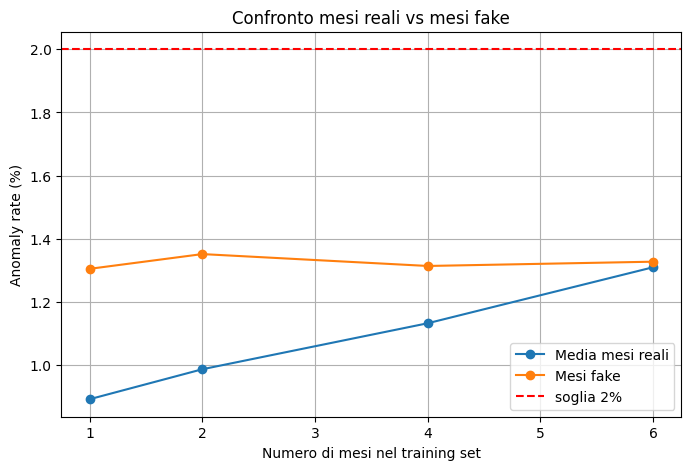

In [15]:
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

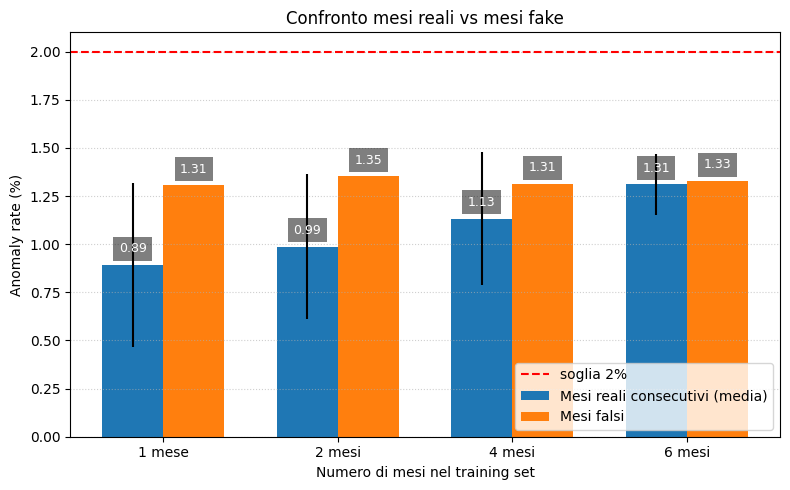

In [16]:
labels = ["1 mese", "2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
# salvataggio dei risultati
# real_results_df.to_csv("/content/drive/MyDrive/CVAE_beta_1_real.csv", index=False)
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
#salvataggio risultati
# fake_results_df.to_csv("/content/drive/MyDrive/CVAE_beta_1_fake.csv", index=False)

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

# Conditional Variational AutoEncoder (CVAE), beta = 0.01

In [3]:
df_temp = pd.read_csv("/content/data_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
new_df = df_temp[(df_temp["timestamp"] < end)]


class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon



class CVAE(keras.Model):
  def __init__(self, input_dim, cond_dim = 1, latent_dim = 2, beta = 0.01, **kwargs):
    super(CVAE, self).__init__(**kwargs)
    self.beta = beta

    #encoder
    x_input = keras.Input(shape=(input_dim,))
    cond_input = keras.Input(shape=(cond_dim,))
    x = layers.Concatenate()([x_input, cond_input])
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(8, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])
    self.encoder = keras.Model([x_input, cond_input], [z_mean, z_log_var, z], name="encoder")

    #decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    cond_inputs_dec = keras.Input(shape=(cond_dim,))
    x = layers.Concatenate()([latent_inputs, cond_inputs_dec])
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(input_dim, activation="linear")(x)

    self.decoder = keras.Model([latent_inputs, cond_inputs_dec], outputs, name="decoder")

  def train_step(self, data):
    (x, cond), y = data

    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder([x, cond], training = True)
      reconstruction = self.decoder([z, cond], training = True)

      reconstruction_loss = tf.reduce_mean(tf.square(x - reconstruction))
      kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + self.beta * kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {"loss": total_loss, "recon_loss": reconstruction_loss, "kl_loss": kl_loss}

  def call(self, inputs):
    x, cond = inputs
    z_mean, _,  z = self.encoder([x, cond])
    return self.decoder([z, cond])





def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

1 mese di dati reali

In [4]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 1
n_months = 12
start_date = new_df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = new_df[(new_df["timestamp"] >= train_start) & (new_df["timestamp"] < train_end)]

  val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  T_train = scaler_T.fit_transform(train_data[cond])

  X_val = scaler_X.transform(val_data[features])
  T_val = scaler_T.transform(val_data[cond])

  cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)
  cvae.compile(optimizer=keras.optimizers.Adam())

  cvae.fit(
      [X_train, T_train],
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = cvae.predict([X_val, T_val])
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_1m = pd.DataFrame(results)
print(results_df_1m)

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   train_months  window_size  anomaly rate
0     [2024-01]            1      0.015178
1     [2024-02]            1      0.012330
2     [2024-03]            1      0.011035
3     [2024-04]            1      0.018647
4     [2024-05]            1      0.014795
5     [2024-06]            1      0.011714
6     [2024-07]            1      0.015258
7     [2024-08]            1      0.006273
8     [2024-09]            1      0.011854
9     [2024-10]            1      0.014880
10    [2024-11]            1      0

2 mesi di dati reali

In [5]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 2
n_months = 12
start_date = new_df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = new_df[(new_df["timestamp"] >= train_start) & (new_df["timestamp"] < train_end)]

  val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  T_train = scaler_T.fit_transform(train_data[cond])

  X_val = scaler_X.transform(val_data[features])
  T_val = scaler_T.transform(val_data[cond])

  cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)
  cvae.compile(optimizer=keras.optimizers.Adam())

  cvae.fit(
      [X_train, T_train],
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = cvae.predict([X_val, T_val])
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
          train_months  window_size  anomaly rate
0   [2024-01, 2024-02]            2      0.018217
1   [2024-02, 2024-03]            2      0.015708
2   [2024-03, 2024-04]            2      0.020892
3   [2024-04, 2024-05]            2      0.016102
4   [2024-05, 2024-06]            2      0.017151
5   [2024-06, 2024-07]            2      0.022335
6   [2024-07, 2024-08]            2      0.014872
7   [2024-08, 2024-09]            2      0.013425
8   [2024-09, 2024-10]            2      0.016509
9   [2024-10, 2024-11]            2      0.016767

4 mesi di dati reali

In [6]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 4
n_months = 12
start_date = new_df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = new_df[(new_df["timestamp"] >= train_start) & (new_df["timestamp"] < train_end)]

  val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  T_train = scaler_T.fit_transform(train_data[cond])

  X_val = scaler_X.transform(val_data[features])
  T_val = scaler_T.transform(val_data[cond])

  cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

  cvae.compile(optimizer=keras.optimizers.Adam())

  cvae.fit(
      [X_train, T_train],
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = cvae.predict([X_val, T_val])
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      0.017441
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      0.018179
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      0.017065
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      0.017586
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.015429
5  [2024-06, 2024-07, 2024-08, 2024-09]            4      0.013316
6  [2024-07, 2024-08, 2024-09, 2024-10]            4      0.012882
7  [2024-08, 2024-09, 2024-10, 2024-11]            4      0.014581
8  [2024-09, 2024-10, 2024-1

6 mesi di dati reali

In [7]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results = []
window_size = 6
n_months = 12
start_date = new_df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = new_df[(new_df["timestamp"] >= train_start) & (new_df["timestamp"] < train_end)]

  val_data = new_df[~new_df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  T_train = scaler_T.fit_transform(train_data[cond])

  X_val = scaler_X.transform(val_data[features])
  T_val = scaler_T.transform(val_data[cond])

  cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

  cvae.compile(optimizer=keras.optimizers.Adam())

  cvae.fit(
      [X_train, T_train],
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = cvae.predict([X_val, T_val])
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   
3  [2024-04, 2024-05, 2024-06, 2024-07, 2024-08, ...            6   
4  [2024-05, 2024-06, 2024-07, 2024-08, 2024-09, ...            6   
5  [2024-06, 2024-07, 2024-08, 2024-09, 2024-10, ...            6   
6  [2024-07, 2024-08, 2024-09, 2024-10, 2024-11, ...            6   

   anomaly rate  
0      0.017982  
1      0.015791  
2      0.015809  
3      0.019620  
4      0.012532  
5      0.013325  
6      0.017145  


1 mese di dati falsi

In [8]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results_1m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.05, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
T_train = scaler_T.fit_transform(train_df[cond])

X_val = scaler_X.transform(valid_df[features])
T_val = scaler_T.transform(valid_df[cond])

cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

cvae.compile(optimizer=keras.optimizers.Adam())

cvae.fit(
    [X_train, T_train],
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = cvae.predict([X_val, T_val])
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_1m_fake.append({"window_size": 1, "anomaly": anomaly_rate})

results_df_1m_fake = pd.DataFrame(results_1m_fake)
print(results_df_1m_fake)

Giorni training: 20
Giorni validation: 584
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
   window_size   anomaly
0            1  0.014839


2 mesi di dati falsi

In [9]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
T_train = scaler_T.fit_transform(train_df[cond])

X_val = scaler_X.transform(valid_df[features])
T_val = scaler_T.transform(valid_df[cond])

cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

cvae.compile(optimizer=keras.optimizers.Adam())

cvae.fit(
    [X_train, T_train],
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = cvae.predict([X_val, T_val])
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

Giorni training: 57
Giorni validation: 547
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size   anomaly
0            2  0.017127


4 mesi di dati falsi

In [10]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
T_train = scaler_T.fit_transform(train_df[cond])

X_val = scaler_X.transform(valid_df[features])
T_val = scaler_T.transform(valid_df[cond])

cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

cvae.compile(optimizer=keras.optimizers.Adam())

cvae.fit(
    [X_train, T_train],
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = cvae.predict([X_val, T_val])
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

Giorni training: 117
Giorni validation: 487
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size   anomaly
0            4  0.016783


6 mesi di dati falsi

In [11]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
cond = ["temperatura"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
scaler_T = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
T_train = scaler_T.fit_transform(train_df[cond])

X_val = scaler_X.transform(valid_df[features])
T_val = scaler_T.transform(valid_df[cond])

cvae = CVAE(input_dim=X_train.shape[1], cond_dim=T_train.shape[1], latent_dim=2)

cvae.compile(optimizer=keras.optimizers.Adam())

cvae.fit(
    [X_train, T_train],
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = cvae.predict([X_val, T_val])
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

Giorni training: 177
Giorni validation: 427
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
   window_size   anomaly
0            6  0.019599


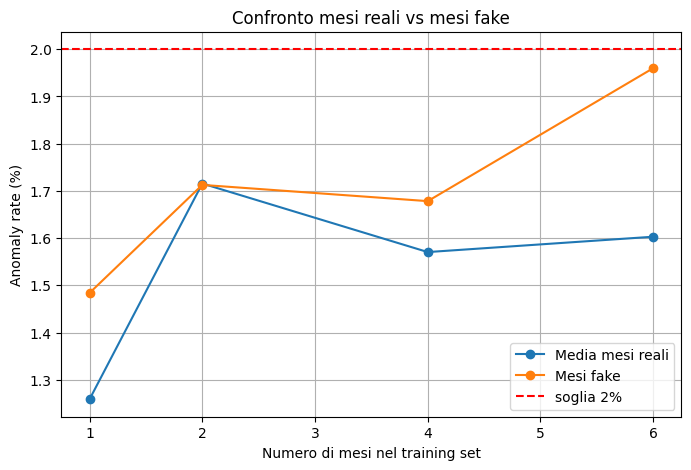

In [12]:
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

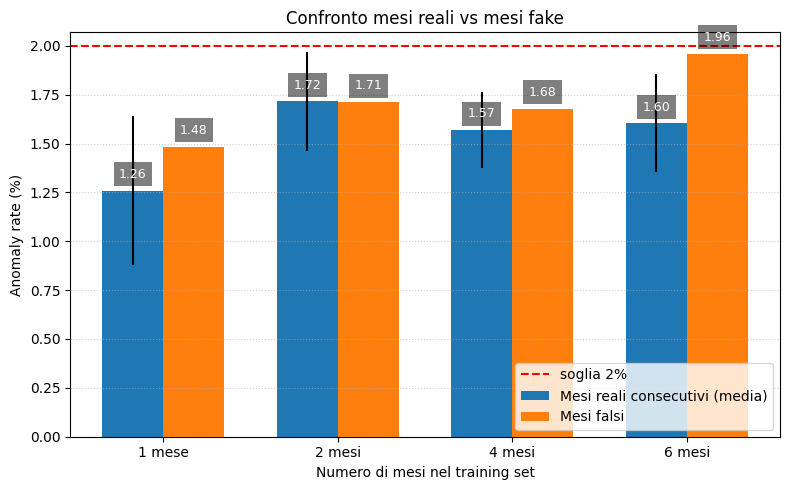

In [13]:
labels = ["1 mese", "2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
# salvataggio dei risultati
# real_results_df.to_csv("/content/drive/MyDrive/CVAE_beta_001_real.csv", index=False)
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
#salvataggio risultati
# fake_results_df.to_csv("/content/drive/MyDrive/CVAE_beta_001_fake.csv", index=False)

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

# Variational AutoEncoder (VAE) senza temperatura

In [3]:
df_original = pd.read_csv("/content/data_no_temperature.csv", encoding = "utf-8")
df_original["timestamp"] = pd.to_datetime(df_original["timestamp"])
df_original["timestamp"] = df_original["timestamp"].dt.tz_localize(None)
df_original = df_original.sort_values("timestamp")

end = "2025-01-01"
df = df_original[(df_original["timestamp"] < end)]

In [4]:
class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
class VAE(keras.Model):
  def __init__(self, input_dim, latent_dim = 2, beta = 0.01, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.beta = beta

    #encoder
    x_input = keras.Input(shape=(input_dim,))
    x = layers.Dense(48, activation="relu")(x_input)
    x = layers.Dense(24, activation="relu")(x)
    x = layers.Dense(12, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])
    self.encoder = keras.Model(x_input, [z_mean, z_log_var, z])

    #decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(12, activation="relu")(latent_inputs)
    x = layers.Dense(24, activation="relu")(x)
    x = layers.Dense(48, activation="relu")(x)
    outputs = layers.Dense(input_dim, activation="linear")(x)

    self.decoder = keras.Model(latent_inputs, outputs)

  def train_step(self, data):
    x, y = data

    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(x, training = True)
      reconstruction = self.decoder(z, training = True)

      reconstruction_loss = tf.reduce_mean(tf.square(x - reconstruction))
      kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + self.beta * kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {"loss": total_loss, "recon_loss": reconstruction_loss, "kl_loss": kl_loss}

  def call(self, inputs):
    z_mean, _,  z = self.encoder(inputs)
    return self.decoder(z)


In [6]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

1 mese di dati reali

In [7]:
# parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 1
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])

  X_val = scaler_X.transform(val_data[features])

  vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = vae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_1m = pd.DataFrame(results)
print(results_df_1m)

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   train_months  window_size  anomaly rate
0     [2024-01]            1      0.011208
1     [2024-02]            1      0.015211
2     [2024-03]            1      0.022767
3     [2024-04]            1      0.019690
4     [2024-05]            1      0.014329
5     [2024-06]            1      0.016585
6     [2024-07]            1      0.016992
7     [2024-08]            1      0.016030
8     [2024-09]            1      0.011621
9     [2024-10]            1      0.014648
10    [2024-11]            1      0

2 mesi di dati reali

In [8]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 2
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])

  X_val = scaler_X.transform(val_data[features])

  vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = vae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
          train_months  window_size  anomaly rate
0   [2024-01, 2024-02]            2      0.013121
1   [2024-02, 2024-03]            2      0.011021
2   [2024-03, 2024-04]            2      0.020764
3   [2024-04, 2024-05]            2      0.017125
4   [2024-05, 2024-06]            2      0.014975
5   [2024-06, 2024-07]            2      0.018655
6   [2024-07, 2024-08]            2      0.016398
7   [2024-08, 2024-09]            2      0.021225
8   [2024-09, 2024-10]            2      0.016765
9   [2024-10, 2024-11]            2      0.020735

4 mesi di dati reali

In [9]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])

  X_val = scaler_X.transform(val_data[features])

  vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = vae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      0.017441
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      0.020234
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      0.020734
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      0.017269
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.014951
5  [2024-06, 2024-07, 2024-08, 2024-09]            4      0.015694
6  [2024-07, 2024-08, 2024-09, 2024-10]            4      0.013995
7  [2024-08, 2024-09, 2024-10, 2024-11]            4      0.016023
8  [2024-09, 2024-10, 2024-1

6 mesi di dati reali

In [10]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 6
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()
  scaler_T = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])

  X_val = scaler_X.transform(val_data[features])

  vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = vae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   
3  [2024-04, 2024-05, 2024-06, 2024-07, 2024-08, ...            6   
4  [2024-05, 2024-06, 2024-07, 2024-08, 2024-09, ...            6   
5  [2024-06, 2024-07, 2024-08, 2024-09, 2024-10, ...            6   
6  [2024-07, 2024-08, 2024-09, 2024-10, 2024-11, ...            6   

   anomaly rate  
0      0.019040  
1      0.020569  
2      0.018971  
3      0.014557  
4      0.016992  
5      0.015440  
6      0.018646  


1 mese di dati falsi

In [11]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_1m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.05, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_1m_fake.append({"window_size": 1, "anomaly": anomaly_rate})

results_df_1m_fake = pd.DataFrame(results_1m_fake)
print(results_df_1m_fake)

Giorni training: 20
Giorni validation: 584
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size   anomaly
0            1  0.017224


2 mesi di dati falsi

In [12]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

Giorni training: 57
Giorni validation: 547
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            2  0.018613


4 mesi di dati falsi

In [13]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

Giorni training: 117
Giorni validation: 487
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            4  0.018524


6 mesi di dati falsi

In [14]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

vae = VAE(input_dim=X_train.shape[1], latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

Giorni training: 177
Giorni validation: 427
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            6  0.018064


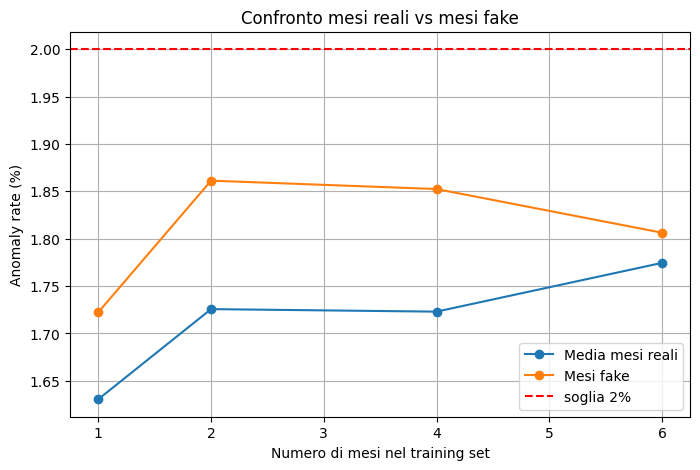

In [15]:
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

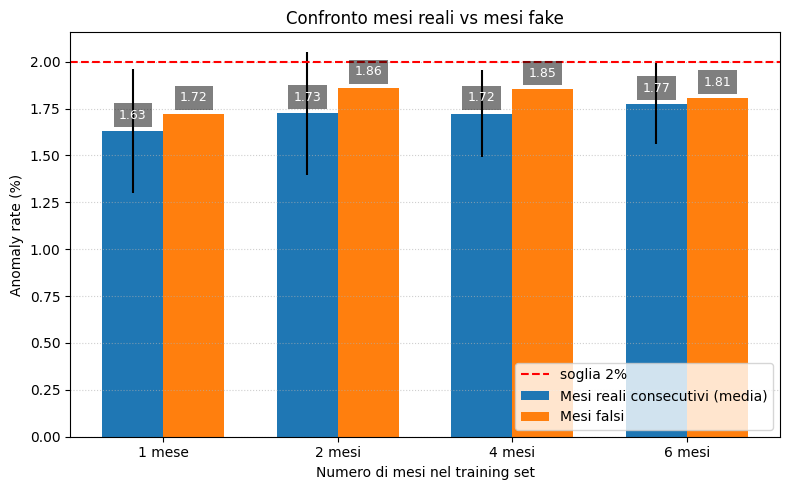

In [16]:
labels = ["1 mese", "2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
# salvataggio dei risultati
# real_results_df.to_csv("/content/drive/MyDrive/VAE_no_temp_real.csv", index=False)
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
#salvataggio risultati
# fake_results_df.to_csv("/content/drive/MyDrive/VAE_no_temp_fake.csv", index=False)

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

# Variational AutoEncoder (VAE) con temperatura

In [3]:
df_temp = pd.read_csv("/content/data_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
df = df_temp[(df_temp["timestamp"] < end)]

In [4]:
class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
class VAE(keras.Model):
  def __init__(self, input_dim, output_dim, latent_dim = 2, beta = 0.01, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.beta = beta

    #encoder
    x_input = keras.Input(shape=(input_dim,))
    x = layers.Dense(32, activation="relu")(x_input)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(8, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])
    self.encoder = keras.Model(x_input, [z_mean, z_log_var, z])

    #decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(8, activation="relu")(latent_inputs)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(output_dim, activation="linear")(x)

    self.decoder = keras.Model(latent_inputs, outputs)

  def train_step(self, data):
    x, y = data

    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(x, training = True)
      reconstruction = self.decoder(z, training = True)

      reconstruction_loss = tf.reduce_mean(tf.square(x[:, :6] - reconstruction))
      kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + self.beta * kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {"loss": total_loss, "recon_loss": reconstruction_loss, "kl_loss": kl_loss}

  def call(self, inputs):
    z_mean, _,  z = self.encoder(inputs)
    return self.decoder(z)


In [6]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

1 mese di dati reali

In [7]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 1
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]
  Y_val = X_val[:, :6]

  vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = vae.predict(X_val)
  mse = np.mean(np.square(Y_val - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_1m = pd.DataFrame(results)
print(results_df_1m)

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   train_months  window_size  anomaly rate
0     [2024-01]            1      0.012259
1     [2024-02]            1      0.016133
2     [2024-03]            1      0.018353
3     [2024-04]            1      0.021427
4     [2024-05]            1      0.014911
5     [2024-06]            1      0.011598
6     [2024-07]            1      0.013293
7     [2024-08]            1      0.013358
8     [2024-09]            1      0.010808
9     [2024-10]            1      0.012788
10    [2024-11]            1      0

2 mesi di dati reali

In [8]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 2
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]
  Y_val = X_val[:, :6]

  vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = vae.predict(X_val)
  mse = np.mean(np.square(Y_val - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
          train_months  window_size  anomaly rate
0   [2024-01, 2024-02]            2      0.016561
1   [2024-02, 2024-03]            2      0.015708
2   [2024-03, 2024-04]            2      0.022038
3   [2024-04, 2024-05]            2      0.018275
4   [2024-05, 2024-06]            2      0.014719
5   [2024-06, 2024-07]            2      0.016878
6   [2024-07, 2024-08]            2      0.019067
7   [2024-08, 2024-09]            2      0.016750
8   [2024-09, 2024-10]            2      0.016253
9   [2024-10, 2024-11]            2      0.016639

4 mesi di dati reali

In [9]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 4
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]
  Y_val = X_val[:, :6]

  vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = vae.predict(X_val)
  mse = np.mean(np.square(Y_val - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      0.015855
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      0.017230
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      0.017065
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      0.015526
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.014156
5  [2024-06, 2024-07, 2024-08, 2024-09]            4      0.015377
6  [2024-07, 2024-08, 2024-09, 2024-10]            4      0.012246
7  [2024-08, 2024-09, 2024-10, 2024-11]            4      0.015062
8  [2024-09, 2024-10, 2024-1

6 mesi di dati reali

In [10]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 6
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]
  Y_val = X_val[:, :6]

  vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1], latent_dim=2)

  vae.compile(optimizer=keras.optimizers.Adam())

  vae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = vae.predict(X_val)
  mse = np.mean(np.square(Y_val - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   
3  [2024-04, 2024-05, 2024-06, 2024-07, 2024-08, ...            6   
4  [2024-05, 2024-06, 2024-07, 2024-08, 2024-09, ...            6   
5  [2024-06, 2024-07, 2024-08, 2024-09, 2024-10, ...            6   
6  [2024-07, 2024-08, 2024-09, 2024-10, 2024-11, ...            6   

   anomaly rate  
0      0.019463  
1      0.017661  
2      0.020025  
3      0.017300  
4      0.015506  
5      0.014805  
6      0.019288  


1 mese di dati falsi

In [11]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_1m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.05, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

Y_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_1m_fake.append({"window_size": 1, "anomaly": anomaly_rate})

results_df_1m_fake = pd.DataFrame(results_1m_fake)
print(results_df_1m_fake)

Giorni training: 20
Giorni validation: 584
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            1  0.015436


2 mesi di dati falsi

In [12]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

Y_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

Giorni training: 57
Giorni validation: 547
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            2  0.017976


4 mesi di dati falsi

In [13]:
# parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

Y_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

Giorni training: 117
Giorni validation: 487
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            4  0.018604


6 mesi di dati falsi

In [14]:
# parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

vae = VAE(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

Y_pred = vae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

Giorni training: 177
Giorni validation: 427
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            6  0.018335


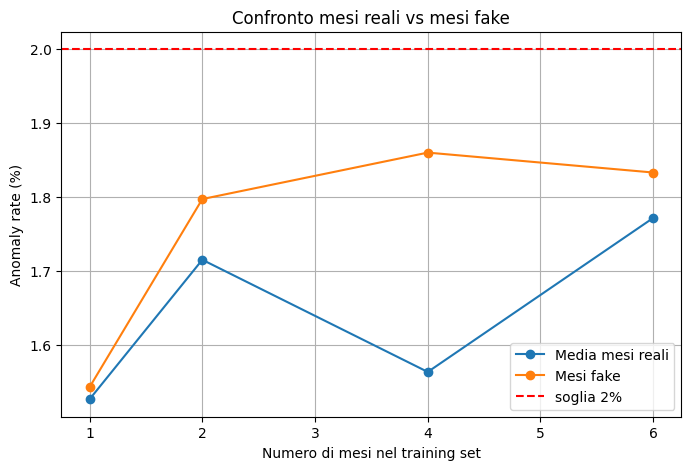

In [15]:
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

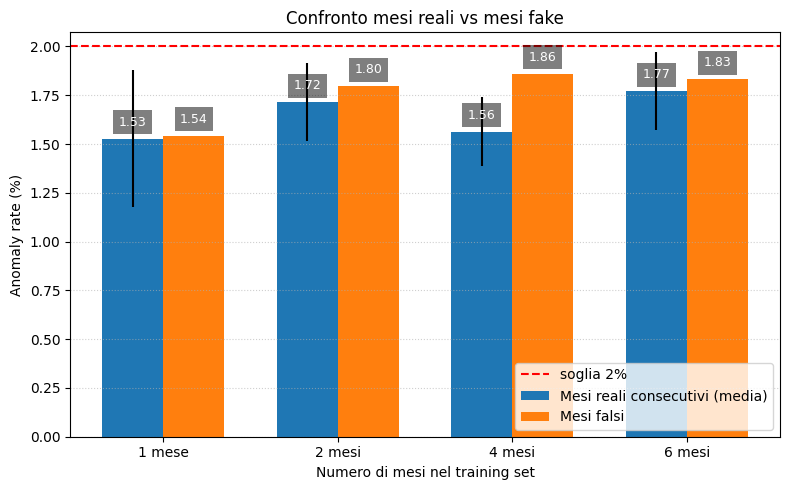

In [16]:
labels = ["1 mese", "2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
# salvataggio dei risultati
# real_results_df.to_csv("/content/drive/MyDrive/VAE_temp_real.csv", index=False)
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
#salvataggio risultati
# fake_results_df.to_csv("/content/drive/MyDrive/VAE_temp_fake.csv", index=False)

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

# AutoEncoder (AE) senza temperatura

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [4]:
df_original = pd.read_csv("/content/data_no_temperature.csv", encoding = "utf-8")
df_original["timestamp"] = pd.to_datetime(df_original["timestamp"])
df_original["timestamp"] = df_original["timestamp"].dt.tz_localize(None)
df_original = df_original.sort_values("timestamp")

end = "2025-01-01"
df = df_original[(df_original["timestamp"] < end)]

In [5]:
def build_ae(input_dim, latent_dim=2):
  #encoder
  input_enc = layers.Input(shape=(input_dim,))
  x = layers.Dense(64, activation="relu")(input_enc)
  x = layers.Dense(32, activation="relu")(x)
  x = layers.Dense(16, activation="relu")(x)
  z = layers.Dense(latent_dim, activation="relu", name="latent")(x)

  #decoder
  x = layers.Dense(16, activation="relu")(z)
  x = layers.Dense(32, activation="relu")(x)
  x = layers.Dense(64, activation="relu")(x)
  output_dec = layers.Dense(input_dim, activation="linear")(x)

  #autoencoder
  ae = keras.Model(input_enc, output_dec, name="autoencoder")
  ae.compile(optimizer="adam", loss="mse")
  return ae

In [6]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

1 mese di dati reali

In [7]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 1
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

  ae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_1m = pd.DataFrame(results)
print(results_df_1m)

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
   train_months  window_size  anomaly rate
0     [2024-01]            1      0.015995
1     [2024-02]            1      0.015441
2     [2024-03]            1      0.015681
3     [2024-04]            1      0.020037
4     [2024-05]            1      0.016892
5     [2024-06]            1      0.014266
6     [2024-07]            1      0.017108
7     [2024-08]            1      0.016959
8     [2024-09]            1      0.013829
9     [2024-10]            1      0.017787
10    [2024-11]            1      0

2 mesi di dati reali

In [8]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 2
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

  ae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
          train_months  window_size  anomaly rate
0   [2024-01, 2024-02]            2      0.020510
1   [2024-02, 2024-03]            2      0.015455
2   [2024-03, 2024-04]            2      0.021783
3   [2024-04, 2024-05]            2      0.018147
4   [2024-05, 2024-06]            2      0.016255
5   [2024-06, 2024-07]            2      0.019036
6   [2024-07, 2024-08]            2      0.017923
7   [2024-08, 2024-09]            2      0.014576
8   [2024-09, 2024-10]            2      0.013821
9   [2024-10, 2024-11]            2      0.017791

4 mesi di dati reali

In [9]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

  ae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      0.016648
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      0.020708
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      0.018501
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      0.020596
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.012884
5  [2024-06, 2024-07, 2024-08, 2024-09]            4      0.015377
6  [2024-07, 2024-08, 2024-09, 2024-10]            4      0.015267
7  [2024-08, 2024-09, 2024-10, 2024-11]            4      0.016504
8  [2024-09, 2024-10, 2024-1

6 mesi di dati reali

In [10]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 6
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

  ae.fit(
      X_train,
      X_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  X_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val - X_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   
3  [2024-04, 2024-05, 2024-06, 2024-07, 2024-08, ...            6   
4  [2024-05, 2024-06, 2024-07, 2024-08, 2024-09, ...            6   
5  [2024-06, 2024-07, 2024-08, 2024-09, 2024-10, ...            6   
6  [2024-07, 2024-08, 2024-09, 2024-10, 2024-11, ...            6   

   anomaly rate  
0      0.016289  
1      0.018284  
2      0.013280  
3      0.012236  
4      0.015930  
5      0.017343  
6      0.016074  


1 mese di dati falsi

In [11]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_1m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.05, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

ae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_1m_fake.append({"window_size": 1, "anomaly": anomaly_rate})

results_df_1m_fake = pd.DataFrame(results_1m_fake)
print(results_df_1m_fake)

Giorni training: 20
Giorni validation: 584
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            1  0.015502


2 mesi di dati falsi

In [12]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

ae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

Giorni training: 57
Giorni validation: 547
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            2  0.011253


4 mesi di dati falsi

In [13]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

ae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

Giorni training: 117
Giorni validation: 487
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            4  0.015833


6 mesi di dati falsi

In [14]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])

X_val = scaler_X.transform(valid_df[features])

ae = build_ae(input_dim=X_train.shape[1], latent_dim=2)

ae.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
  )

X_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val - X_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

Giorni training: 177
Giorni validation: 427
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
   window_size   anomaly
0            6  0.016438


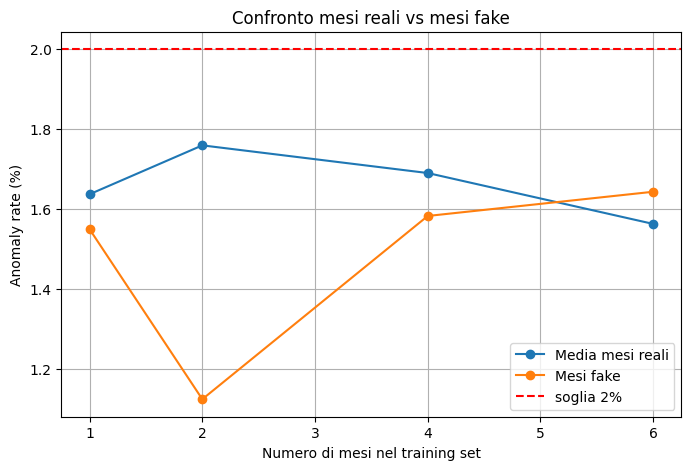

In [15]:
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

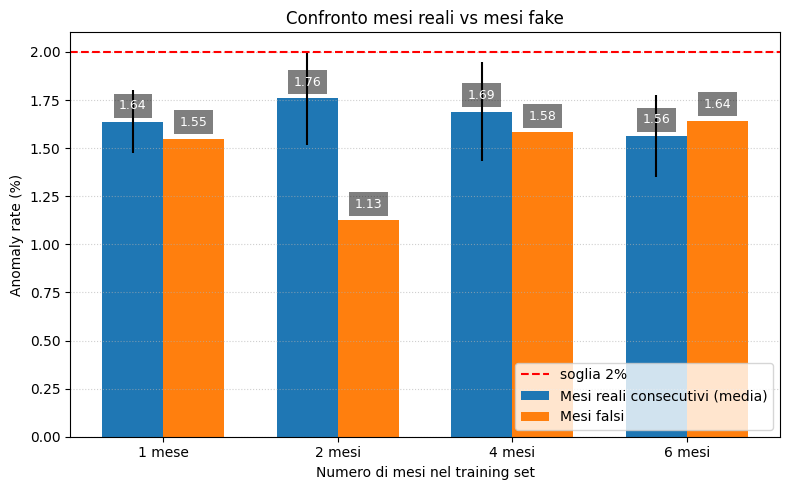

In [16]:
labels = ["1 mese", "2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
# salvataggio dei risultati
# real_results_df.to_csv("/content/drive/MyDrive/AE_no_temp_real.csv", index=False)
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
#salvataggio risultati
# fake_results_df.to_csv("/content/drive/MyDrive/AE_no_temp_fake.csv", index=False)

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

# AutoEncoder (AE) con temperatura

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [4]:
df_temp = pd.read_csv("/content/data_temperature.csv", encoding = "utf-8")
df_temp["timestamp"] = pd.to_datetime(df_temp["timestamp"])
df_temp["timestamp"] = df_temp["timestamp"].dt.tz_localize(None)
df_temp = df_temp.sort_values("timestamp")

end = "2025-01-01"
df = df_temp[(df_temp["timestamp"] < end)]

In [5]:
def build_ae_temp(input_dim = 7, output_dim = 6, latent_dim=2):
  #encoder
  input_enc = layers.Input(shape=(input_dim,))
  x = layers.Dense(48, activation="relu")(input_enc)
  x = layers.Dense(24, activation="relu")(x)
  z = layers.Dense(latent_dim, activation="relu", name="latent")(x)

  #decoder
  x = layers.Dense(24, activation="relu")(z)
  x = layers.Dense(48, activation="relu")(x)
  output_dec = layers.Dense(output_dim, activation="linear")(x)

  #autoencoder
  ae = keras.Model(input_enc, output_dec, name="autoencoder")
  ae.compile(optimizer="adam", loss="mse")
  return ae

In [6]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

1 mese di dati reali

In [7]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 1
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]

  ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

  ae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_1m = pd.DataFrame(results)
print(results_df_1m)

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
   train_months  window_size  anomaly rate
0     [2024-01]            1      0.015178
1     [2024-02]            1      0.012791
2     [2024-03]            1      0.019398
3     [2024-04]            1      0.016678
4     [2024-05]            1      0.015960
5     [2024-06]            1      0.012642
6     [2024-07]            1      0.018842
7     [2024-08]            1      0.015681
8     [2024-09]            1      0.010691
9     [2024-10]            1      0.014880
10    [2024-11]            1      0

2 mesi di dati reali

In [8]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 2
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]

  ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

  ae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
          train_months  window_size  anomaly rate
0   [2024-01, 2024-02]            2      0.020255
1   [2024-02, 2024-03]            2      0.013428
2   [2024-03, 2024-04]            2      0.020000
3   [2024-04, 2024-05]            2      0.016102
4   [2024-05, 2024-06]            2      0.017151
5   [2024-06, 2024-07]            2      0.017132
6   [2024-07, 2024-08]            2      0.013728
7   [2024-08, 2024-09]            2      0.014065
8   [2024-09, 2024-10]            2      0.016509
9   [2024-10, 2024-11]            2      0.017791

4 mesi di dati reali

In [9]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 4
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]

  ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

  ae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      0.018234
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      0.014859
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      0.017225
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      0.017427
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.015747
5  [2024-06, 2024-07, 2024-08, 2024-09]            4      0.016170
6  [2024-07, 2024-08, 2024-09, 2024-10]            4      0.013995
7  [2024-08, 2024-09, 2024-10, 2024-11]            4      0.017305
8  [2024-09, 2024-10, 2024-1

6 mesi di dati reali

In [10]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results = []
window_size = 6
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  scaler_X = StandardScaler()

  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  Y_train = X_train[:, :6]

  ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

  ae.fit(
      X_train,
      Y_train,
      epochs = 50,
      batch_size = 64,
      verbose = 0
  )

  Y_pred = ae.predict(X_val)
  mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

  mean_mse = np.mean(mse)
  std_mse = np.std(mse)
  threshold = mean_mse + 3 * std_mse
  anomalies = mse > threshold
  anomaly_rate = np.mean(anomalies)
#  anomaly_rate = np.mean(anomalies)*100

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   
3  [2024-04, 2024-05, 2024-06, 2024-07, 2024-08, ...            6   
4  [2024-05, 2024-06, 2024-07, 2024-08, 2024-09, ...            6   
5  [2024-06, 2024-07, 2024-08, 2024-09, 2024-10, ...            6   
6  [2024-07, 2024-08, 2024-09, 2024-10, 2024-11, ...            6   

   anomaly rate  
0      0.019040  
1      0.022855  
2      0.016653  
3      0.014768  
4      0.014444  
5      0.017343  
6      0.017574  


1 mese di dati falsi

In [11]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_1m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.05, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

ae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
)

Y_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_1m_fake.append({"window_size": 1, "anomaly": anomaly_rate})

results_df_1m_fake = pd.DataFrame(results_1m_fake)
print(results_df_1m_fake)

Giorni training: 20
Giorni validation: 584
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            1  0.015634


2 mesi di dati falsi

In [12]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

ae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
)

Y_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

Giorni training: 57
Giorni validation: 547
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   window_size   anomaly
0            2  0.019462


4 mesi di dati falsi

In [13]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

ae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
)

Y_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

Giorni training: 117
Giorni validation: 487
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   window_size   anomaly
0            4  0.017891


6 mesi di dati falsi

In [14]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6", "temperatura"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_temp, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

Y_train = X_train[:, :6]

ae = build_ae_temp(input_dim=X_train.shape[1], output_dim=Y_train.shape[1] , latent_dim=2)

ae.fit(
    X_train,
    Y_train,
    epochs = 50,
    batch_size = 64,
    verbose = 0
)

Y_pred = ae.predict(X_val)
mse = np.mean(np.square(X_val[:, :6] - Y_pred), axis=1)

mean_mse = np.mean(mse)
std_mse = np.std(mse)
threshold = mean_mse + 3 * std_mse
anomalies = mse > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

Giorni training: 177
Giorni validation: 427
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
   window_size   anomaly
0            6  0.018154


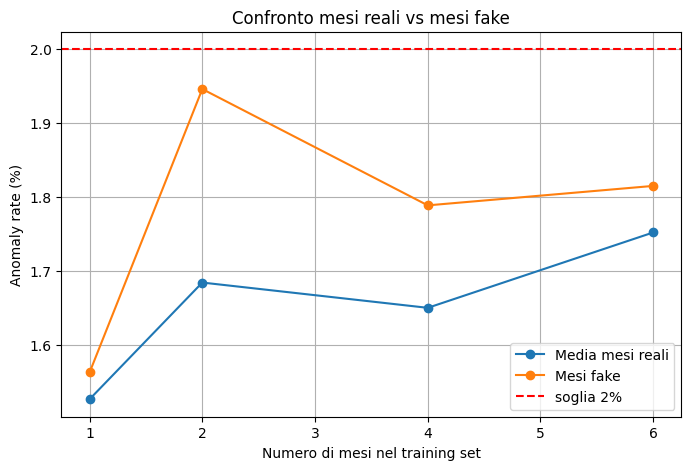

In [15]:
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

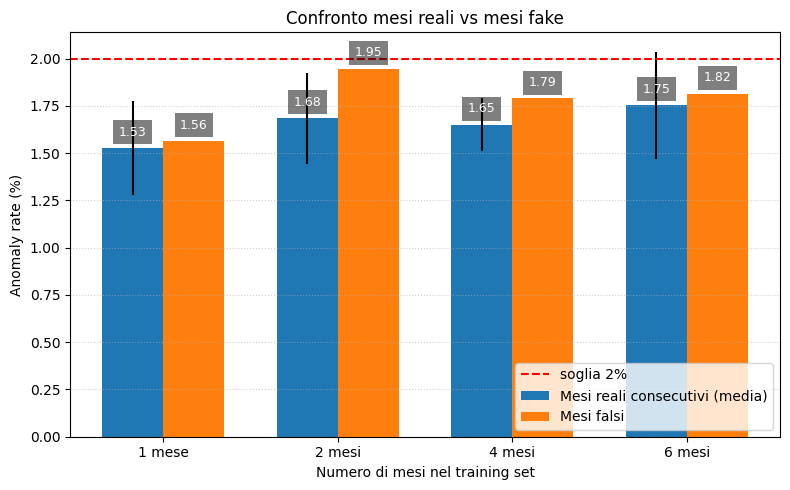

In [16]:
labels = ["1 mese", "2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
# salvataggio dei risultati
# real_results_df.to_csv("/content/drive/MyDrive/AE_temp_real.csv", index=False)
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
#salvataggio risultati
# fake_results_df.to_csv("/content/drive/MyDrive/AE_temp_fake.csv", index=False)

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

# Deep Support Vector Data Description (SVDD)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [ ]:
df_original = pd.read_csv("/content/data_no_temperature.csv", encoding = "utf-8")
df_original["timestamp"] = pd.to_datetime(df_original["timestamp"])
df_original["timestamp"] = df_original["timestamp"].dt.tz_localize(None)
df_original = df_original.sort_values("timestamp")

end = "2025-01-01"
df = df_original[(df_original["timestamp"] < end)]

In [ ]:
def build_svdd_model(input_dim, latent_dim=2):
  inputs = layers.Input(shape=(input_dim,))
  x = layers.Dense(32, activation="relu")(inputs)
  x = layers.Dense(16, activation="relu")(x)
  latent = layers.Dense(latent_dim, activation=None)(x)
  model = keras.Model(inputs, latent, name="DeepSVDD")
  return model

def compute_center(model, X):
  Z = model.predict(X, verbose=0)
  c = np.mean(Z, axis=0)
  return tf.constant(c, dtype=tf.float32)

@tf.function
def svdd_loss(model, x, c, nu=0.1):
  z = model(x, training=True)
  dist = tf.reduce_sum(tf.square(z - c), axis=1)
  loss = tf.reduce_mean(dist)
  return loss, dist

def train_svdd(model, X_train, epochs=50, batch_size=64, lr=1e-4):
  c = compute_center(model, X_train)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      loss, _ = svdd_loss(model, tf.constant(X_train, dtype=tf.float32), c)
      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} - Loss: {loss.numpy():.4f}")
        return c

In [ ]:
def create_fake_month(df, frac_per_month, random_state):
  rng = np.random.default_rng(seed=random_state) # generatore casuale con seed
  df["day"] = df["timestamp"].dt.floor("D")
  df["year_month"] = df["timestamp"].dt.to_period("M")
  train_indices = []

  for ym, group in df.groupby("year_month"):
    days = group["day"].unique()
    n_take = max(1, int(len(days) * frac_per_month))
    sampled_days = rng.choice(days, size=n_take, replace=False)
    sel = group[group["day"].isin(sampled_days)].index.tolist()
    train_indices += sel

  train_df = df.loc[train_indices].copy()
  valid_df = df.drop(index=train_indices).copy()
  train_df = train_df.drop(columns=["day", "year_month"])
  valid_df = valid_df.drop(columns=["day", "year_month"])
  train_df = train_df.sort_values("timestamp")
  valid_df = valid_df.sort_values("timestamp")

  return train_df, valid_df

1 mese di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 1
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  # Preprocessing
  scaler_X = StandardScaler()
  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  # Modello Deep SVDD
  input_dim = X_train.shape[1]

  model = build_svdd_model(input_dim=input_dim, latent_dim=2)
  c = train_svdd(model, X_train, epochs=50, lr=1e-4)
  Z_val = model.predict(X_val, verbose=0)
  dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

  threshold = dist_val.mean() + 3 * dist_val.std()
  anomalies = dist_val > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_1m = pd.DataFrame(results)
print(results_df_1m)

2 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 2
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  # Preprocessing
  scaler_X = StandardScaler()
  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  # Modello Deep SVDD
  input_dim = X_train.shape[1]

  model = build_svdd_model(input_dim=input_dim, latent_dim=2)
  c = train_svdd(model, X_train, epochs=50, lr=1e-4)
  Z_val = model.predict(X_val, verbose=0)
  dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

  threshold = dist_val.mean() + 3 * dist_val.std()
  anomalies = dist_val > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_2m = pd.DataFrame(results)
print(results_df_2m)

Epoch 000 - Loss: 0.1104
Epoch 000 - Loss: 0.1244
Epoch 000 - Loss: 0.2186
Epoch 000 - Loss: 0.2236


Epoch 000 - Loss: 0.2686


Epoch 000 - Loss: 0.3123
Epoch 000 - Loss: 0.1350
Epoch 000 - Loss: 0.1792
Epoch 000 - Loss: 0.1591
Epoch 000 - Loss: 0.2105
Epoch 000 - Loss: 0.3884
          train_months  window_size  anomaly rate
0   [2024-01, 2024-02]            2      0.019873
1   [2024-02, 2024-03]            2      0.014821
2   [2024-03, 2024-04]            2      0.022675
3   [2024-04, 2024-05]            2      0.018530
4   [2024-05, 2024-06]            2      0.022655
5   [2024-06, 2024-07]            2      0.023096
6   [2024-07, 2024-08]            2      0.014745
7   [2024-08, 2024-09]            2      0.017005
8   [2024-09, 2024-10]            2      0.016637
9   [2024-10, 2024-11]            2      0.016255
10  [2024-11, 2024-12]            2      0.010681


4 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 4
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  # Preprocessing
  scaler_X = StandardScaler()
  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  # Modello Deep SVDD
  input_dim = X_train.shape[1]

  model = build_svdd_model(input_dim=input_dim, latent_dim=2)
  c = train_svdd(model, X_train, epochs=50, lr=1e-4)
  Z_val = model.predict(X_val, verbose=0)
  dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

  threshold = dist_val.mean() + 3 * dist_val.std()
  anomalies = dist_val > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_4m = pd.DataFrame(results)
print(results_df_4m)

Epoch 000 - Loss: 0.1614
Epoch 000 - Loss: 0.1860
Epoch 000 - Loss: 0.1843
Epoch 000 - Loss: 0.0934
Epoch 000 - Loss: 0.2001
Epoch 000 - Loss: 0.1527
Epoch 000 - Loss: 0.2308
Epoch 000 - Loss: 0.1460
Epoch 000 - Loss: 0.1254
                           train_months  window_size  anomaly rate
0  [2024-01, 2024-02, 2024-03, 2024-04]            4      0.019185
1  [2024-02, 2024-03, 2024-04, 2024-05]            4      0.023396
2  [2024-03, 2024-04, 2024-05, 2024-06]            4      0.025199
3  [2024-04, 2024-05, 2024-06, 2024-07]            4      0.016952
4  [2024-05, 2024-06, 2024-07, 2024-08]            4      0.019882
5  [2024-06, 2024-07, 2024-08, 2024-09]            4      0.013475
6  [2024-07, 2024-08, 2024-09, 2024-10]            4      0.021310
7  [2024-08, 2024-09, 2024-10, 2024-11]            4      0.020189
8  [2024-09, 2024-10, 2024-11, 2024-12]            4      0.022125


6 mesi di dati reali

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results = []
window_size = 6
n_months = 12
start_date = df["timestamp"].min()

for m in range(1, n_months - window_size + 2):
  train_start = start_date + pd.DateOffset(months=m-1)
  train_end = start_date + pd.DateOffset(months=m-1+window_size)
  train_data = df[(df["timestamp"] >= train_start) & (df["timestamp"] < train_end)]

  val_data = df[~df["timestamp"].isin(train_data["timestamp"])]

  # Preprocessing
  scaler_X = StandardScaler()
  X_train = scaler_X.fit_transform(train_data[features])
  X_val = scaler_X.transform(val_data[features])

  # Modello Deep SVDD
  input_dim = X_train.shape[1]

  model = build_svdd_model(input_dim=input_dim, latent_dim=2)
  c = train_svdd(model, X_train, epochs=50, lr=1e-4)
  Z_val = model.predict(X_val, verbose=0)
  dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

  threshold = dist_val.mean() + 3 * dist_val.std()
  anomalies = dist_val > threshold
  anomaly_rate = np.mean(anomalies)

  train_months = sorted(train_data["timestamp"].dt.to_period("M").unique())
  results.append({"train_months": [str(x) for x in train_months], "window_size": len(train_months), "anomaly rate": anomaly_rate})

results_df_6m = pd.DataFrame(results)
print(results_df_6m)

Epoch 000 - Loss: 0.1222
Epoch 000 - Loss: 0.1253
Epoch 000 - Loss: 0.1602
Epoch 000 - Loss: 0.1934
Epoch 000 - Loss: 0.1946
Epoch 000 - Loss: 0.3386
Epoch 000 - Loss: 0.2506
                                        train_months  window_size  \
0  [2024-01, 2024-02, 2024-03, 2024-04, 2024-05, ...            6   
1  [2024-02, 2024-03, 2024-04, 2024-05, 2024-06, ...            6   
2  [2024-03, 2024-04, 2024-05, 2024-06, 2024-07, ...            6   
3  [2024-04, 2024-05, 2024-06, 2024-07, 2024-08, ...            6   
4  [2024-05, 2024-06, 2024-07, 2024-08, 2024-09, ...            6   
5  [2024-06, 2024-07, 2024-08, 2024-09, 2024-10, ...            6   
6  [2024-07, 2024-08, 2024-09, 2024-10, 2024-11, ...            6   

   anomaly rate  
0      0.012058  
1      0.020985  
2      0.017074  
3      0.016667  
4      0.016355  
5      0.018613  
6      0.016288  


1 mese di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_1m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.05, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

# Modello Deep SVDD
input_dim = X_train.shape[1]

model = build_svdd_model(input_dim=input_dim, latent_dim=2)
c = train_svdd(model, X_train, epochs=50, lr=1e-4)
Z_val = model.predict(X_val, verbose=0)
dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

threshold = dist_val.mean() + 3 * dist_val.std()
anomalies = dist_val > threshold
anomaly_rate = np.mean(anomalies)


results_1m_fake.append({"window_size": 1, "anomaly": anomaly_rate})

results_df_1m_fake = pd.DataFrame(results_1m_fake)
print(results_df_1m_fake)

2 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_2m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.1, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

# Modello Deep SVDD
input_dim = X_train.shape[1]

model = build_svdd_model(input_dim=input_dim, latent_dim=2)
c = train_svdd(model, X_train, epochs=50, lr=1e-4)
Z_val = model.predict(X_val, verbose=0)
dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

threshold = dist_val.mean() + 3 * dist_val.std()
anomalies = dist_val > threshold
anomaly_rate = np.mean(anomalies)


results_2m_fake.append({"window_size": 2, "anomaly": anomaly_rate})

results_df_2m_fake = pd.DataFrame(results_2m_fake)
print(results_df_2m_fake)

Giorni training: 57
Giorni validation: 547
Epoch 000 - Loss: 0.1238
   window_size   anomaly
0            2  0.022647


4 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_4m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.2, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

# Modello Deep SVDD
input_dim = X_train.shape[1]

model = build_svdd_model(input_dim=input_dim, latent_dim=2)
c = train_svdd(model, X_train, epochs=50, lr=1e-4)
Z_val = model.predict(X_val, verbose=0)
dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

threshold = dist_val.mean() + 3 * dist_val.std()
anomalies = dist_val > threshold
anomaly_rate = np.mean(anomalies)


results_4m_fake.append({"window_size": 4, "anomaly": anomaly_rate})

results_df_4m_fake = pd.DataFrame(results_4m_fake)
print(results_df_4m_fake)

Giorni training: 117
Giorni validation: 487
Epoch 000 - Loss: 0.2425
   window_size   anomaly
0            4  0.020108


6 mesi di dati falsi

In [ ]:
#parametri
features = ["Mode 1", "Mode 2", "Mode 3", "Mode 4", "Mode 5", "Mode 6"]
results_6m_fake = []
train_df, valid_df = create_fake_month(df_original, frac_per_month=0.3, random_state=42)

print("Giorni training:", train_df["timestamp"].dt.date.nunique())
print("Giorni validation:", valid_df["timestamp"].dt.date.nunique())

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(train_df[features])
X_val = scaler_X.transform(valid_df[features])

# Modello Deep SVDD
input_dim = X_train.shape[1]

model = build_svdd_model(input_dim=input_dim, latent_dim=2)
c = train_svdd(model, X_train, epochs=50, lr=1e-4)
Z_val = model.predict(X_val, verbose=0)
dist_val = np.sum((Z_val - c.numpy()) ** 2, axis=1)

threshold = dist_val.mean() + 3 * dist_val.std()
anomalies = dist_val > threshold
anomaly_rate = np.mean(anomalies)


results_6m_fake.append({"window_size": 6, "anomaly": anomaly_rate})

results_df_6m_fake = pd.DataFrame(results_6m_fake)
print(results_df_6m_fake)

Giorni training: 177
Giorni validation: 427
Epoch 000 - Loss: 0.2358
   window_size   anomaly
0            6  0.018967


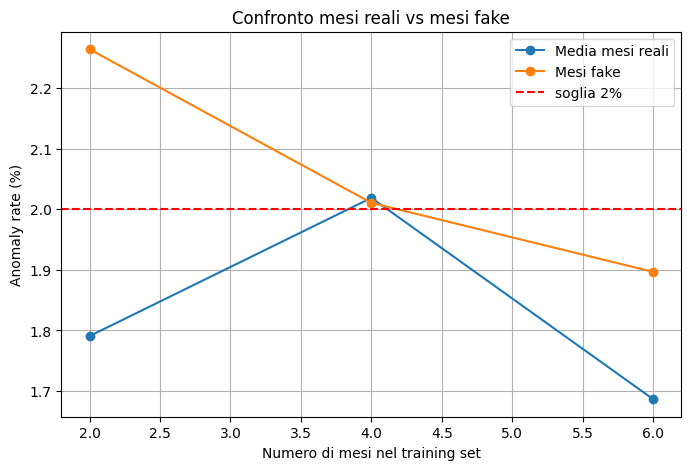

In [ ]:
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])
plt.figure(figsize=(8,5))
plt.plot(real_mean["window_size"], real_mean["anomaly rate"]*100, "o-", label="Media mesi reali")
plt.plot(fake_results_df["window_size"], fake_results_df["anomaly"]*100, "o-", label="Mesi fake")
plt.axhline(2, color="r", linestyle="--", label="soglia 2%")
plt.xlabel("Numero di mesi nel training set")
plt.ylabel("Anomaly rate (%)")
plt.title("Confronto mesi reali vs mesi fake")
plt.legend()
plt.grid(True)

plt.show()

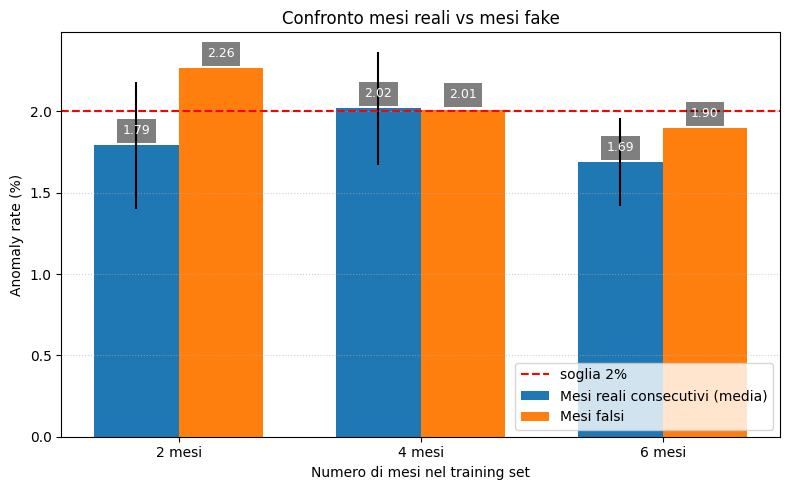

In [ ]:
labels = ["1 mese", "2 mesi", "4 mesi", "6 mesi"]
real_results_df = pd.concat([results_df_1m, results_df_2m, results_df_4m, results_df_6m])
real_mean = real_results_df.groupby("window_size")["anomaly rate"].mean().reset_index()
real_std = real_results_df.groupby("window_size")["anomaly rate"].std().reset_index()

fake_results_df = pd.concat([results_df_1m_fake, results_df_2m_fake, results_df_4m_fake, results_df_6m_fake])

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - w/2, real_mean["anomaly rate"]*100, w, yerr= real_std["anomaly rate"]*100, label="Mesi reali consecutivi (media)")
bars2 = ax.bar(x + w/2, fake_results_df["anomaly"]*100, w, label="Mesi falsi")
ax.axhline(2, color="r", linestyle="--", label="soglia 2%")
ax.set_xlabel("Numero di mesi nel training set")
ax.set_ylabel("Anomaly rate (%)")
ax.set_title("Confronto mesi reali vs mesi fake")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.6)

def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.05,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="white",
        bbox = dict(facecolor="black", alpha=0.5, edgecolor="none")
    )

add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()